In [1]:
import scipy.stats as stats
import sigfig as sf
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle
import os

import helper_functions as hf

In [2]:
tfbsType='AP1'
tfName='AP1'


expname='GEUV'

In [3]:
tfCore='NTKANNMA'

tfAllPossible8mers=hf.IupacToAllPossibleSequences(tfCore)
tfAllPossible8mers+=[hf.revcomp(seq) for seq in tfAllPossible8mers]


In [4]:
def getAll8mers(seq,p,ref,alt):
    
    altLenAdj=len(ref)-len(alt)
        
    if altLenAdj==0:
        seq=seq[p-7:p+8]    
        seqRef=seq[:7]+ref+seq[7+1:]
        seqAlt=seq[:7]+alt+seq[7+1:]
        
    elif altLenAdj>0:
        seq=seq[p-7:p+8+altLenAdj]    
        seqRef=seq[:7]+ref+seq[7+1:-altLenAdj]
        seqAlt=seq[:7]+alt+seq[7+1:]
    else:
        raise ValueError('ref/alt not allowed yet')
    
    # if len(seqRef)!=len(seqAlt):
        # raise ValueError('ref/alt seqs not dovetailed')
        
    for i,end in enumerate(range(7,len(seq)-altLenAdj)):
        start=end-7
        last=end+1
        kmer8Ref=seqRef[start:last]
        kmer8Alt=seqAlt[start:last]
            
        yield kmer8Ref,kmer8Alt


In [5]:
def is_tf_8mer(kmer8):
    if kmer8 in tfAllPossible8mers:            return True
    else:                                      return False

# Set up logic for creating/deleting ets sites
BeforeAfter2tfLogic={
    (0,0):'Tf Never',
    (1,1):'Tf Always',
    (0,1):'Tf Created',
    (1,0):'Tf Deleted'
}

In [6]:

def snv_tf_analysis(chrom,idx1,ref,alt,chr2seq,tf2aff):
    
    # Ensure data is snp, no indels
    prohibitedPolyTypes=['Other']
    if len(ref)==1 and len(alt)==1: 
        polymorphismType='SNV'
        
    elif len(ref)==1 and len(alt)==0:
        polymorphismType='SND'
        
    else:
        polymorphismType='Other'
        
    if polymorphismType in prohibitedPolyTypes:
        return 'Variant Type Not Allowed Yet'
        
    ######################################
    # Verify ref/alt matches genomic bp
    ######################################
    
    if 'chr' not in chrom: chrom=f'chr{chrom}'
    
    # Check if pos in genome is same as declared REF
    idx0=int(idx1)-1
    snvNtInGenome=chr2seq[chrom][idx0]
    if ref==snvNtInGenome:    
        checkSnv='REF'
    elif alt==snvNtInGenome:  
        checkSnv='ALT'
    else:                     
        return f'Genomic bp does not match expectation: \n  expected ref/alt = ({ref}/{alt})\n  observed = {snvNtInGenome}'
    
    
    ######################################
    # Assess if SNV is in ETS
    ######################################
    
    tfChanged=False
    for kmer8,kmer8mut in getAll8mers(chr2seq[chrom],idx0,ref,alt):

        ba=(is_tf_8mer(kmer8),is_tf_8mer(kmer8mut)) # before after logic
        tfLogic=BeforeAfter2tfLogic[ba]

        # If ets-changing snp found, write it out
        if tfLogic=='Tf Always': 
            tfChanged=True
            refaff=tf2aff[kmer8]
            altaff=tf2aff[kmer8mut]
            
            return tfLogic,refaff,altaff,altaff/refaff,kmer8,kmer8mut
        
        elif tfLogic=='Tf Created':
            return tfLogic,kmer8,kmer8mut
            
        elif tfLogic=='Tf Deleted':
            return tfLogic,kmer8,kmer8mut

    if tfChanged==False:
        return 'Variant not in Tf',kmer8,kmer8mut




# Load ref data

In [7]:
# ap1
ref  =f'preprocessed-data//parsed_Jun_Fos_8mers_core=TGANTMA_max=TGAGTCAT.txt'
Seq2EtsAff  = hf.loadAff(ref)
hf.dprint(Seq2EtsAff)


# hg38
ref=f'/Users/joe/code/ref/genomes/human/hg38/fasta/hg38.fa'
chr2seq=hf.faLoadGenome(ref)

AAAAAAAC 0.28640095325611686


# Analysis options

In [8]:
fcOptCutoff=1.5
# fcOptCutoff=2
# fcOptCutoff=3.46
# fcOptCutoff=5

# Load MPRA data

In [9]:
fn=f'preprocessed-data/QTD000110__readyForInput__matteoCorrMethod_keepOnlyTewheyMPRAVariants=False_removeMixedGofLofVariants=False_genomeWideSigAdj=True.tsv'

df=pd.read_csv(fn,sep='\t')
df.head(2)

/var/folders/r8/cnsr_ylj6qd449cvnpt46c6w0000gn/T/ipykernel_4605/3685288924.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(fn,sep='\t')


,chrom,pos,rsid,ref,alt,beta,pvalue-bonf,gene-id
0,1,624836,rs1220600689,G,A,0.940218,2.706912e-02,ENSG00000237491
1,1,656599,rs1265125318,C,T,1.175120,9.004911e-11,ENSG00000237491


In [10]:
# only snvs
df=df.loc[(df.ref.str.len()==1) & (df.alt.str.len()==1),:]

In [11]:
len(df)

369912

In [12]:
## New one which grabs 8mer ref and  8mer alt  regardlesso f snv  type

variantTypeList=[]
refAffList=[]
altAffList=[]
fcList=[]
ref8merlist=[]
alt8merlist=[]

for idx in df.index:
    
    chrom,pos,ref,alt=[df.at[idx,ci] for ci in ['chrom','pos','ref','alt']]

    if alt=='-': alt=''
    resultList=snv_tf_analysis(str(chrom),pos,ref,alt,chr2seq,Seq2EtsAff)
    result=resultList[0]
    
    if result=='Variant not in Tf':
        result,kmer8,kmer8mut=resultList
        variantTypeList.append('Not In Tf')
        refAffList.append(np.NaN)
        altAffList.append(np.NaN)
        fcList.append(np.NaN)
        ref8merlist.append(kmer8)
        alt8merlist.append(kmer8mut)


    elif result=='Tf Created':
        result,kmer8,kmer8mut=resultList
        variantTypeList.append('Tf Created')
        refAffList.append(np.NaN)
        altAffList.append(np.NaN)
        fcList.append(np.NaN)
        ref8merlist.append(kmer8)
        alt8merlist.append(kmer8mut)


    elif result=='Tf Deleted':
        result,kmer8,kmer8mut=resultList
        variantTypeList.append('Tf Deleted')
        refAffList.append(np.NaN)
        altAffList.append(np.NaN)
        fcList.append(np.NaN)
        ref8merlist.append(kmer8)
        alt8merlist.append(kmer8mut)

        
    else:
        variantType,refAff,altAff,fc,kmer8ref,kmer8alt=resultList
        variantTypeList.append(variantType)
        refAffList.append(refAff)
        altAffList.append(altAff)
        fcList.append(fc)
        ref8merlist.append(kmer8ref)
        alt8merlist.append(kmer8alt)

        
        
    

In [13]:
df['variant-type']=variantTypeList
df['aff-ref']=refAffList
df['aff-alt']=altAffList
df['aff-fc']=fcList
df['kmer-ref']=ref8merlist
df['kmer-alt']=alt8merlist

df['aff-delta']=df.apply(lambda row: row['aff-alt']-row['aff-ref'],axis=1)

In [14]:
df['variant-type'].value_counts()

Not In Tf     328065
Tf Created     14630
Tf Deleted     14329
Tf Always      12888
Name: variant-type, dtype: int64

In [15]:
df=df.loc[df['pvalue-bonf']<.01,:]
df['-log(p)']=df['pvalue-bonf'].apply(lambda p: -np.log10(p))
df['-log(p)*direction']=df.apply(lambda r: r['-log(p)'] if r['beta']>=0 else -r['-log(p)'],axis=1)
df['-log(p)*direction']=df['-log(p)*direction'].replace(-0,0)

In [16]:
df['pvalue-bonf'].max()

0.0099996102304098

In [17]:
df['pvalue-bonf'].min()

4.488672107634e-167

In [18]:
df['variant-type'].value_counts()

Not In Tf     296946
Tf Created     13276
Tf Deleted     13025
Tf Always      11641
Name: variant-type, dtype: int64

In [19]:
df['chrompos']=df['chrom'].apply(lambda c: 'chr'+str(c))+df['pos'].apply(str)
print(len(df['chrompos']))
print(len(df['chrompos'].unique()))

334888
246431


In [20]:
print(len(df))
df=df.drop_duplicates()
print(len(df))

334888
334888


# Prediction accuracy vs random (for nature)

In [21]:
pvalCutoff=.05
logSigCutoff=abs(np.log10(pvalCutoff))

deNovoThresh=.25

fcOptCutoff=1.5

fcDecCutoff=sf.round(1/fcOptCutoff,3)

fcNoChangeCutoff_Inc=1.25
fcNoChangeCutoff_Dec=sf.round(1/fcNoChangeCutoff_Inc,3)

# get variants to predict on
predDF=df.loc[:,:]

# assign prediction labels
                           # make this ever so slightly lower than 0 to avoid having bin edges be the same
bins=[-np.inf,-logSigCutoff-1e-100,logSigCutoff,np.inf]
predDF['classification']=pd.cut(predDF['-log(p)*direction'],bins=bins,labels=['Sig Decrease','N.S.','Sig Increase'])

# assign predictions
etsLabels=[]

for fc,classification,kmer,kmerMut in hf.zipdf(predDF,['aff-fc','variant-type','kmer-ref','kmer-alt']):

    # not in tf
    if classification=='Not In Tf':
        anno='not-in-tf'

    # delet tf
    elif classification=='Tf Deleted':
        anno='del-tf'

    elif classification=='Tf Created':

        denovoaff=Seq2EtsAff[kmerMut]

        if denovoaff<deNovoThresh:
            anno=f'de-novo-tf-low-aff\n<{deNovoThresh}'            

        elif denovoaff>=deNovoThresh:
            anno=f'de-novo-tf-high-aff\n>={deNovoThresh}'

    #  dramatic iincrase
    elif fc>=fcOptCutoff:
        anno=f'dramatic-increase\n>={fcOptCutoff}'

    #  dramatic incrase
    elif fc<=fcDecCutoff:
        # print(fc,classification)
        anno=f'dramatic-decrease\n<={fcDecCutoff}'

    # no increase
    elif fc<=fcNoChangeCutoff_Inc and fc>=fcNoChangeCutoff_Dec:
        anno=f'no-change-aff\n<={fcNoChangeCutoff_Inc}\n>={fcNoChangeCutoff_Dec}'

    else:
        # print(fc,classification,kmer,kmerMut)
        anno='subtle-change'


    etsLabels.append(anno)

predDF['tf-class']=etsLabels

line_out=hf.write_row(['snv-group','total','effect-ns','effect-gof','effect-lof'])

for classi in predDF['tf-class'].unique():
    nClassi=predDF['tf-class'].value_counts()[classi]

    ns,gof,lof=[predDF.loc[predDF['tf-class']==classi,'classification'].value_counts()[ci] for ci in ['N.S.','Sig Increase','Sig Decrease']]

    line_out+=hf.write_row([classi.replace('\n',' '),nClassi,ns,gof,lof])

print(line_out)
with open(f'FOR-NATURE-STATS-PREDICTIONS-{expname}-{tfName}__fdr.tsv','w') as f: f.write(line_out)

/Users/joe/miniconda3/lib/python3.9/site-packages/sigfig/sigfig.py:586: UserWarning: warning: 3 significant figures requested from number with only 1 significant figures
  warn("warning: %d significant figures requested from number with only %d significant figures" % (given['sigfigs'], len(num.map)))


snv-group	total	effect-ns	effect-gof	effect-lof
not-in-tf	296946	0	144958	151988
subtle-change	1874	0	898	976
no-change-aff <=1.25 >=0.8	9310	0	4333	4977
de-novo-tf-high-aff >=0.25	12016	0	5825	6191
del-tf	13025	0	6142	6883
dramatic-increase >=1.5	238	0	113	125
de-novo-tf-low-aff <0.25	1260	0	648	612
dramatic-decrease <=0.667	219	0	111	108



In [22]:
altHypothesis='less'

datalabels_subset_v2=[
[f'not-in-tf',f'del-tf',f'dramatic-decrease\n<={fcDecCutoff}',f'de-novo-tf-low-aff\n<{deNovoThresh}',f'de-novo-tf-high-aff\n>={deNovoThresh}','subtle-change'],
[f'no-change-aff\n<={fcNoChangeCutoff_Inc}\n>={fcNoChangeCutoff_Dec}'],
[f'dramatic-increase\n>={fcOptCutoff}'],
]

data2color={
(f'no-change-aff\n<={fcNoChangeCutoff_Inc}\n>={fcNoChangeCutoff_Dec}',):'lightgrey',
(f'dramatic-increase\n>={fcOptCutoff}',):'forestgreen',
(f'not-in-tf',f'del-tf',f'dramatic-decrease\n<={fcDecCutoff}',f'de-novo-tf-low-aff\n<{deNovoThresh}',f'de-novo-tf-high-aff\n>={deNovoThresh}','subtle-change'):'dimgrey'}


plotDF=predDF.loc[:,:].reset_index().copy(deep=True)

In [23]:
rsid2mostsigrow={}

for i,(rsid,pvalue) in enumerate(hf.zipdf(plotDF,['rsid','pvalue-bonf'])):
    
    if rsid not in rsid2mostsigrow:
        rsid2mostsigrow[rsid]=i
        
    else:
        #update if this is more sig
        if pvalue<rsid2mostsigrow[rsid]:
            rsid2mostsigrow[rsid]=i

idxToKeep=rsid2mostsigrow.values()
plotDF=plotDF.loc[idxToKeep,:]

group1	group2	p
not-in-tf+del-tf+dramatic-decrease <=0.667+de-novo-tf-low-aff <0.25+de-novo-tf-high-aff >=0.25+subtle-change	no-change-aff <=1.25 >=0.8	0.845
not-in-tf+del-tf+dramatic-decrease <=0.667+de-novo-tf-low-aff <0.25+de-novo-tf-high-aff >=0.25+subtle-change	dramatic-increase >=1.5	0.04863



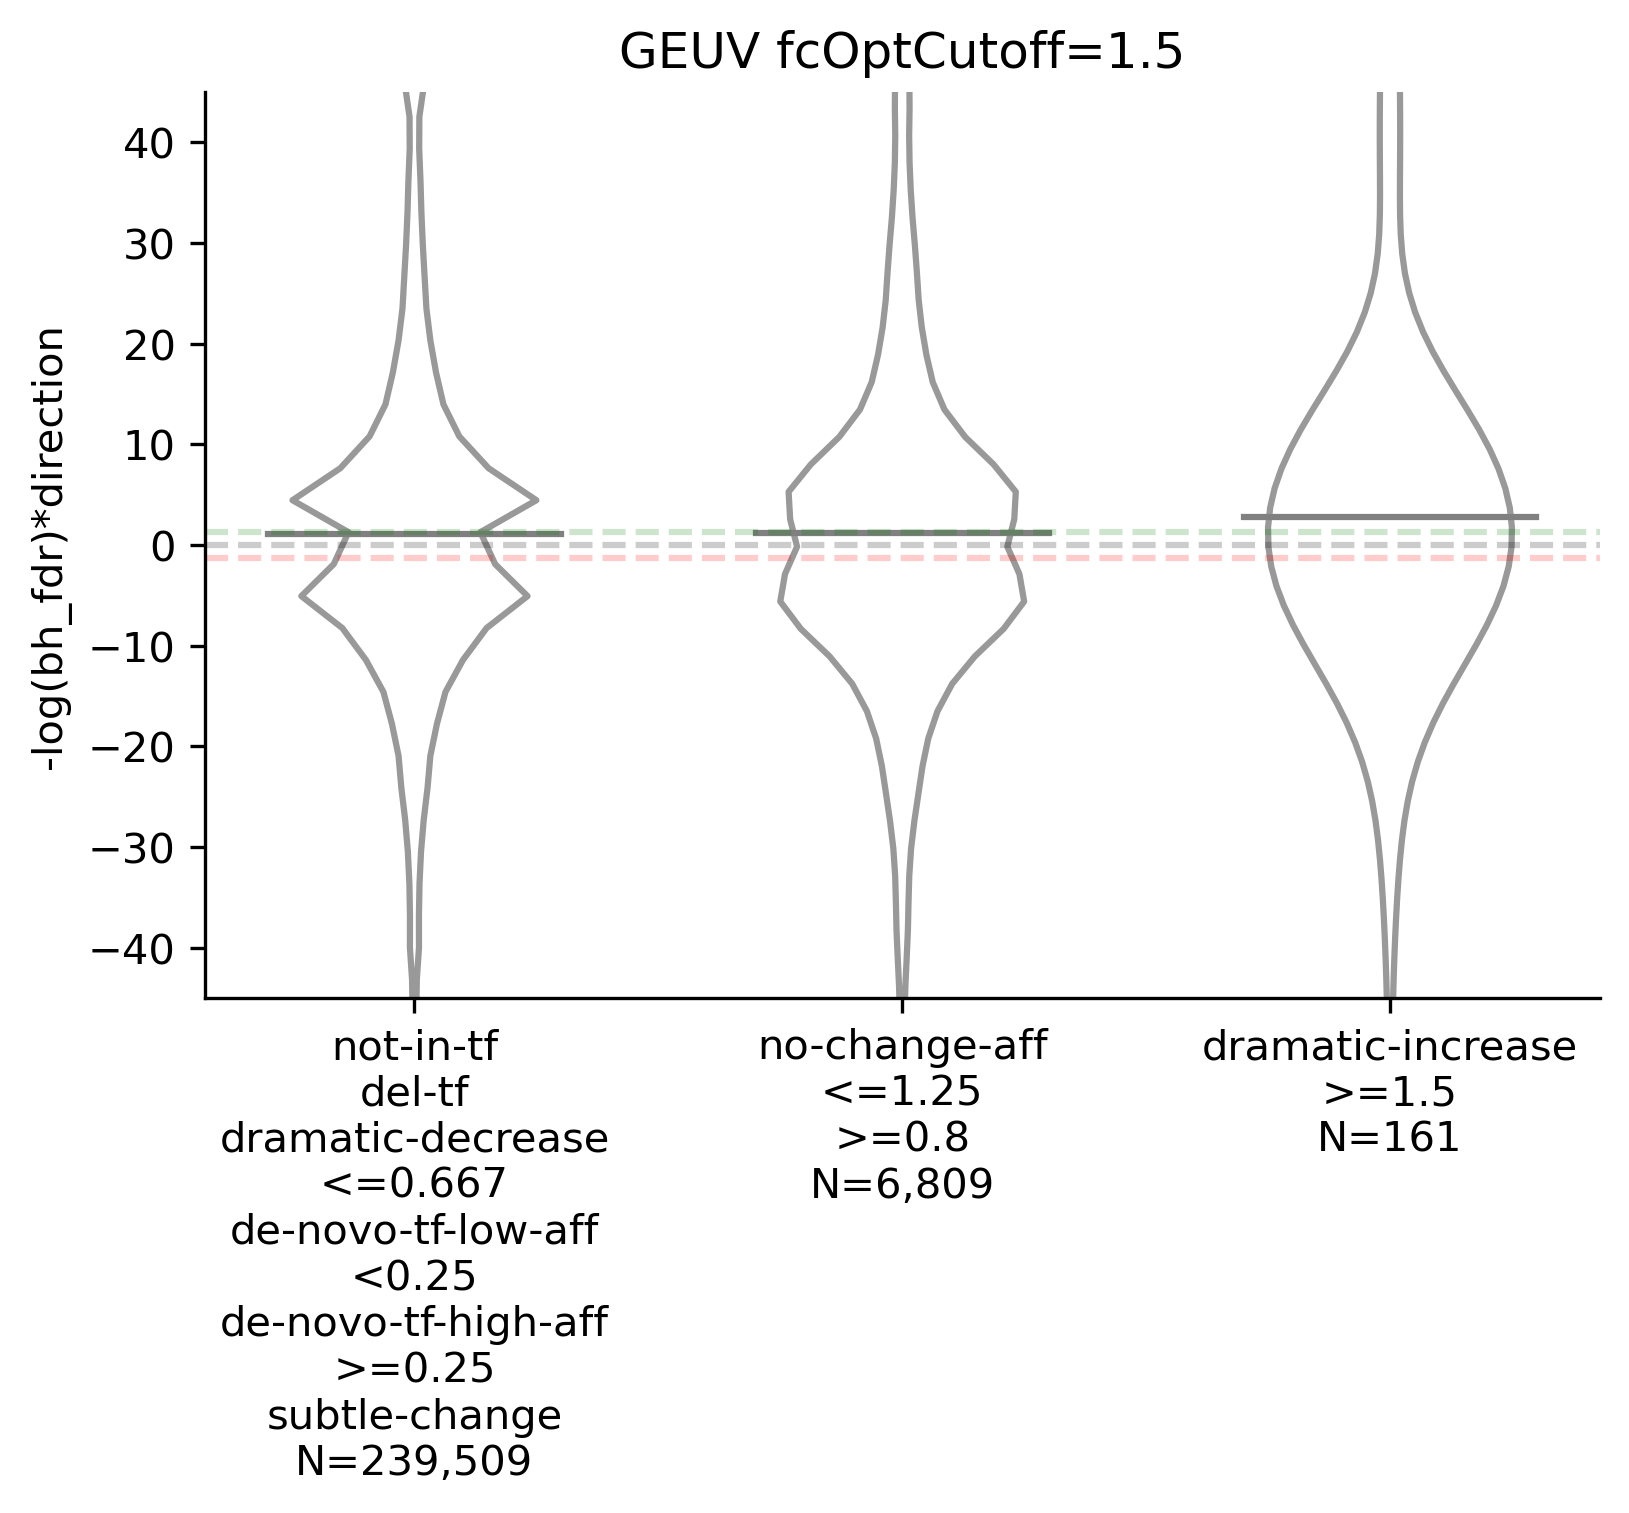

In [24]:
violin=True
boxplot=False

data=[]
for di in datalabels_subset_v2:
    datai=[]
    for dj in di:
        datai+=plotDF.loc[(plotDF['tf-class']==dj),'-log(p)*direction'].tolist()
    data.append(datai)

line_out=hf.write_row(['group1','group2','p'])

############################################################################
# Stats
############################################################################

dCtrlNameList=datalabels_subset_v2[0]
dCtrl=plotDF.loc[(plotDF['tf-class'].isin(dCtrlNameList)),'-log(p)*direction']

for diNameList in datalabels_subset_v2[1:]:

    di=plotDF.loc[(plotDF['tf-class'].isin(diNameList)),'-log(p)*direction']

    try:
        _ , p =stats.mannwhitneyu(dCtrl,di,alternative=altHypothesis)
    except ValueError:
        pass


    line_out+=hf.write_row(['+'.join(dCtrlNameList).replace('\n',' '),'+'.join(diNameList).replace('\n',' '),sf.round(p,4)])

print(line_out)
with open(f'FOR-NATURE__violin-stats__{tfName}__{expname}.tsv','w') as f: f.write(line_out)

############################################################################
# Stats
############################################################################

fig,ax=plt.subplots(1,1,figsize=(2*len(datalabels_subset_v2),4),dpi=300,facecolor='white')

palette=[data2color[tuple(di)] for di in datalabels_subset_v2]

if violin:
    sns.violinplot(data=data,color='white',inner=None,cut=0,ax=ax,width=.5,scale='width')

    meanlinewidth=.3
    for xi,di in enumerate(data):
        val=np.mean(di)
        ax.plot([xi-meanlinewidth,xi+meanlinewidth],[val,val],color='grey')

if boxplot:
    sns.boxplot(data=data,color='white',ax=ax,fliersize=0)#,palette=palette)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

axticklabels=['\n'.join(label) for label in datalabels_subset_v2]
ax.set_xticklabels([f'{label}\nN={len(points):,}' for label,points in zip(axticklabels,data)])
ax.set_ylabel('-log(bh_fdr)*direction')

ax.axhline(-np.log10(.05),ls='--',color='green',alpha=.2)
ax.axhline(np.log10(.05),ls='--',color='red',alpha=.2)
ax.axhline(np.log10(1),ls='--',color='black',alpha=.2)

ax.set_title(f'{expname} fcOptCutoff={fcOptCutoff}')

ax.set_ylim(-45,45)


# plt.savefig(f'/Users/joe/Desktop/ets-kircher-elements={idList}.png')# ,bbox_inches='tight')
plt.show()

plotDF.to_csv(f'NATURE-ALL-DATA_{tfName}_{expname}.tsv',sep='\t',index=None)
